# PyTorch TensorBoard Support

This notebook is based on the following tutorials and sites:

- [PyTorch TensorBoard Support](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html)
- [Visualizing Models, Data, and Training with TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
- [Documentation: torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html?highlight=summarywriter)
- [How to use TensorBoard with PyTorch](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-tensorboard-with-pytorch.md)

Here, the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset is used to train a CNN, while using Tensorboard to perform the following monitoring tasks:

- Save sampled experiment images.
- Log training metrics:
  - Train and validation loss.
  - Weight histograms
- Visualize model graph.
- Visualize embeddings (not working - check [`../embeddings/`](../embeddings/) instead)
- Model evaluation: PR curves.
- Get a python list of values logged to Tensorboard.

The overall idea is to instantiate a `writer = SummaryWriter(...)` with a `logdir` and to add elements to it wherever and whenever we need, as explained in the [documentation site of torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html?highlight=summarywriter):

- `write.add_scalar(...)`
- `write.add_scalars(...)`
- `write.add_histogram(...)`
- `write.add_image(...)`
- `write.add_images(...)`
- `write.add_figure(...)`
- `write.add_video(...)`
- `write.add_audio(...)`
- `write.add_text(...)`
- `write.add_graph(...)`
- `write.add_embedding(...)`
- `write.add_pr_curve(...)`
- `write.add_custom_scalars(...)`
- `write.add_mesh(...)`
- `write.add_hparams(...)`

Then, we do `write.flush()` to write to disk and finally `writer.close()`.

Note that `tensorboard` can be launched and interactively consulted as we add data to it!

```bash
# Don't use blank spaces
tensorboard --logdir=./
# Open borwser at http://localhost:6006/
# Refresh it several times until it works
```

We need to select the approproate tab for display.

Also, note that the dashboard can be open during training, so that the training metrics are monitored in realtime.

In [1]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

# In case you are using an environment that has TensorFlow installed,
# such as Google Colab, uncomment the following code to avoid
# a bug with saving embeddings to your TensorBoard directory

# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

## Showing Images in TensorBoard

Let’s start by adding sample images from our dataset to TensorBoard:

torch.Size([3, 32, 122])


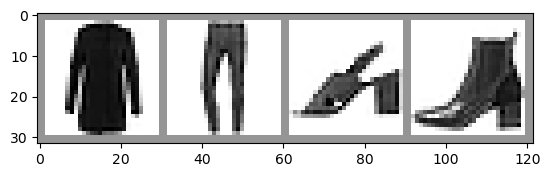

In [2]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('../datasets',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST('../datasets',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

# Class labels
classes = (
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
)

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
print(img_grid.shape)
matplotlib_imshow(img_grid, one_channel=True)

In [3]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
# When we flush, the data is written to disk
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# on a CLI with the propper environment active.
# Open a browser tab to http://localhost:6006/
# and check the IMAGES tab

## Define Model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Weight Histograms

Saving weight histograms is a little bit more clumsy in Pytorch, because we need to create the functions that convert weight tensors into vectors. A possible approach is as follows (taken from the article [*How to use TensorBoard with PyTorch*](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-tensorboard-with-pytorch.md)):

In [5]:
def weight_histograms_conv2d(writer, step, weights, layer_number):
    weights_shape = weights.shape
    num_kernels = weights_shape[0]
    for k in range(num_kernels):
        flattened_weights = weights[k].flatten()
        tag = f"layer_{layer_number}/kernel_{k}"
        writer.add_histogram(tag, flattened_weights, global_step=step, bins='tensorflow')


def weight_histograms_linear(writer, step, weights, layer_number):
    flattened_weights = weights.flatten()
    tag = f"layer_{layer_number}"
    writer.add_histogram(tag, flattened_weights, global_step=step, bins='tensorflow')


def weight_histograms(writer, step, model):
    # Create a list of layers
    layers_list = [
        model.conv1, model.pool, model.conv2,
        model.fc1, model.fc2, model.fc3
    ]

    # Loop over all layers
    for layer_number, layer in enumerate(layers_list):
        # Compute weight histograms for appropriate layer
        if isinstance(layer, nn.Conv2d):
            weights = layer.weight
            weight_histograms_conv2d(writer, step, weights, layer_number)
        elif isinstance(layer, nn.Linear):
            weights = layer.weight
            weight_histograms_linear(writer, step, weights, layer_number)

## Train and Log Metrics

TensorBoard is useful for tracking the progress and efficacy of your training. Below, we’ll run a training loop, track some metrics, and save the data for TensorBoard’s consumption.

In [6]:
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            net.train(False) # Don't need to track gradents for validation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Turn gradients back on for training

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            # Log/Visualize weight histograms
            weight_histograms(writer,
                              epoch * len(training_loader) + i,
                              net)
    
            # Log the running loss averaged per batch
            writer.add_scalars(
                'Training vs. Validation Loss',
                { 'Training' : avg_loss, 'Validation' : avg_vloss },
                epoch * len(training_loader) + i
            )

            running_loss = 0.0
print('Finished Training')

# When we flush, the data is written to disk
writer.flush()

Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


## Visualize the Model

TensorBoard can also be used to examine the data flow within your model. To do this, call the add_graph() method with a model and sample input.

In [7]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(net, images)
writer.flush()

## Visualizing Your Dataset with Embeddings

The 28-by-28 image tiles we’re using can be modeled as 784-dimensional vectors (28 * 28 = 784). It can be instructive to project this to a lower-dimensional representation. The `add_embedding()` method will project a set of data onto the three dimensions with highest variance, and display them as an interactive 3D chart.

**However, this did not work in my case**. Instead, have a look at the [`../embeddings/`](../embeddings/) tutorial.

In [8]:
# These lines are necessary to avoid an error
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [9]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=images.unsqueeze(1))
writer.flush()
writer.close()

## Model Evaluation: PR Curves

In [10]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

## Get a Python List of Values Logged to Tensorboard

Probably there is a better way than the following, but I managed to get Python objects of the logged events/artifacts as shown below. Note that we need to first look into the folder structure and print the keys of the logs. Then, once the metric is detected, we extract it manually.

In [21]:
from tensorboard.backend.event_processing import event_accumulator

# Path to the TensorBoard log directory
# NOTE that we check in the folder structure the metric we want...
#log_dir = "./runs/fashion_mnist_experiment_1/"
log_dir = './runs/fashion_mnist_experiment_1/Training vs. Validation Loss_Training/'
#log_dir = './runs/fashion_mnist_experiment_1/Training vs. Validation Loss_Validation/'

# Load the TensorBoard event files
event_acc = event_accumulator.EventAccumulator(log_dir)
event_acc.Reload()

# Print the list of events
print("Event Keys:", event_acc.Tags())

# Print the list of scalar tags
print("Scalar Tags:", event_acc.scalars.Keys()) # This output should be used

Event Keys: {'images': [], 'audio': [], 'histograms': [], 'scalars': ['Training vs. Validation Loss'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
Scalar Tags: ['Training vs. Validation Loss']


In [22]:
# Get the scalar events (train and validation losses)
_loss_events = event_acc.Scalars('Training vs. Validation Loss')

# Extract the loss values as Python lists
_loss_values = [event.value for event in _loss_events]

# Print the extracted loss values
print("Loss Values:", _loss_values)


Loss Values: [1.9090362787246704, 0.884652853012085, 0.7311283349990845, 0.6646563410758972, 0.6157943606376648, 0.5622122287750244, 0.5244928002357483, 0.5216445326805115, 0.5059792399406433, 0.48864346742630005, 0.4763878583908081, 0.46774783730506897, 0.44335687160491943, 0.42448800802230835, 0.42012035846710205]
